In [1]:
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import diceioumetrics

In [2]:
flair = "C:/Users/Harini Balaji/HariniBalaji/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_flair.nii"
t1ce = "C:/Users/Harini Balaji/HariniBalaji/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_t1ce.nii"
t2 = "C:/Users/Harini Balaji/HariniBalaji/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_t2.nii"
mask ="C:/Users/Harini Balaji/HariniBalaji/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii"

In [3]:
test_image_flair=nib.load(flair).get_fdata()
scaled_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1ce=nib.load(t1ce).get_fdata()
scaled_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(t2).get_fdata()
scaled_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(mask).get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))


[0 1 2 4]
[0 1 2 3]


In [4]:
print("test_mask.shape=",test_mask.shape)

test_mask.shape= (240, 240, 155)


In [5]:
combined_x = np.stack([scaled_image_flair, scaled_image_t1ce, scaled_image_t2], axis=3)

combined_img=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

cat_mask = to_categorical(test_mask, num_classes=4)

print("combined_img.shape=",combined_img.shape)
print("np.unique(test_mask)=",np.unique(test_mask))

combined_img.shape= (128, 128, 128, 3)
np.unique(test_mask)= [0 1 2 3]


In [6]:
!pip install tensorflow_addons

In [7]:
import os
import bratsslmsa
import tensorflow as tf
from bratsslmsa import ShortTermMemoryAttentionBlock, LongTermMemoryAttentionBlock
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
import keras.optimizers as optim
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.utils import custom_object_scope
from tensorflow_addons.optimizers import AdamW
import keras
from diceioumetrics import dice_loss, dice_coefficient, IoUClassMetrics
print(keras.__version__)
print(tf.__version__)
modelpath =  "C:/Users/Harini Balaji/Downloads/brats_slmsa_7diceloss.hdf5"
if os.path.exists(modelpath):
    # Load the model with custom layer registration
    with custom_object_scope({
        'ShortTermMemoryAttentionBlock': ShortTermMemoryAttentionBlock,
        'LongTermMemoryAttentionBlock': LongTermMemoryAttentionBlock,
        'dice_loss':dice_loss,
        'dice_coefficient': dice_coefficient,
        'IoUClassMetrics' : IoUClassMetrics
            }):
        model = load_model(modelpath)
else:
    print(f"The model file '{modelpath}' does not exist.")



C:\HariniLearn\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.15.0
2.14.0


In [8]:
# Predict the mask for the input image
print("combined_img.shape=",combined_img.shape)
combined_img_expanded = np.expand_dims(combined_img, axis=0)
test_prediction = model.predict(combined_img_expanded)
print("test_prediction.shape",test_prediction.shape)
# Assuming your model's output has multiple channels, get the argmax of the last dimension
test_prediction_argmax = np.argmax(test_prediction, axis=4)


print("test_prediction_argmax=",np.unique(test_prediction_argmax))
#print("test_mask_argmax=",np.unique(test_mask_argmax))
print("test_mask=",np.unique(test_mask))
print("test_prediction=",np.unique(test_prediction))


combined_img.shape= (128, 128, 128, 3)
1/1 [==============================] - 5s 5s/step
test_prediction.shape (1, 128, 128, 128, 4)
test_prediction_argmax= [0 1 2 3]
test_mask= [0 1 2 3]
test_prediction= [3.3311633e-26 1.3319889e-25 1.3392646e-25 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


In [9]:
from tensorflow.keras.metrics import MeanIoU
num_classes=4
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(test_prediction_argmax,test_mask)
print("MeanIOU = ",IOU_keras.result().numpy())

MeanIOU =  0.51773924


In [10]:
print("test_prediction_argmax.shape",test_prediction_argmax.shape)
print("test_mask.shape",test_mask.shape)

test_prediction_argmax.shape (1, 128, 128, 128)
test_mask.shape (128, 128, 128)


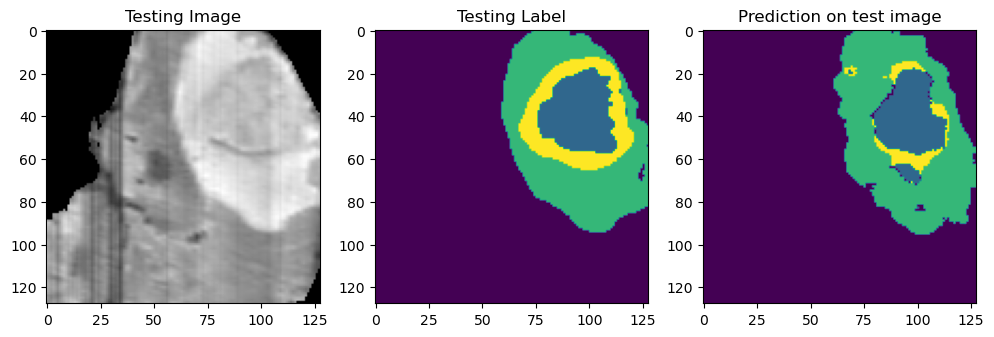

In [11]:
import matplotlib.pyplot as plt
n_slice = 45
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(combined_img[n_slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask[n_slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[0 ,n_slice,:,:])
plt.show()


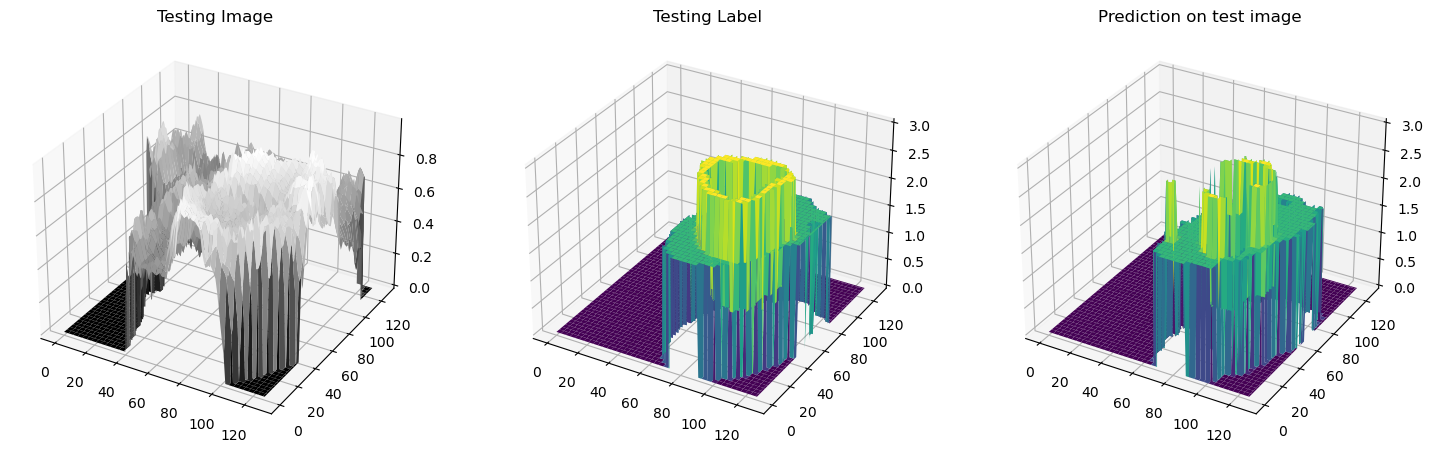

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming combined_img, test_mask, and test_prediction_argmax are your 3D arrays

n_slice = 45

# Create a 3D figure
fig = plt.figure(figsize=(18, 6))

# Plot Testing Image
ax1 = fig.add_subplot(131, projection='3d')
ax1.set_title('Testing Image')
x, y = np.arange(combined_img.shape[1]), np.arange(combined_img.shape[2])
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, combined_img[n_slice, :, :, 0], cmap='gray')

# Plot Testing Label
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title('Testing Label')
X, Y = np.meshgrid(np.arange(test_mask.shape[1]), np.arange(test_mask.shape[2]))
ax2.plot_surface(X, Y, test_mask[n_slice, :, :], cmap='viridis')

# Plot Prediction on test image
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('Prediction on test image')
X, Y = np.meshgrid(np.arange(test_prediction_argmax.shape[2]), np.arange(test_prediction_argmax.shape[3]))
ax3.plot_surface(X, Y, test_prediction_argmax[0, n_slice, :, :], cmap='viridis')

plt.show()


In [13]:
import itk
from itkwidgets import view

In [14]:
new_combined_img = combined_img[..., 0] 
print("new_combined_img.shape=",new_combined_img.shape )

new_combined_img.shape= (128, 128, 128)


In [15]:
new_test_prediction_argmax = test_prediction_argmax[0]
print("new_test_prediction_argmax.shape=",new_test_prediction_argmax.shape )

new_test_prediction_argmax.shape= (128, 128, 128)


In [16]:
view(new_combined_img)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [17]:
view(test_mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [18]:
view(new_test_prediction_argmax)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…